In [5]:
import numpy as np
from astropy import units as u
from astropy.coordinates import Angle
import os 
import folium
from folium import plugins
import IFR_subroutines as subs
import importlib as imp
import matplotlib.pyplot as plt

Select the files to use:

In [6]:
potential_good = '../DATA/gps_pos_default_v2.snx'
#potential_try = '../DATA/potential_stations_350_DRAO' #create this somehow at some point!
actual_good = '../DATA/albus_good_stations_DRAO_CHIME_220121_3day_500km_5m' # Note: Allenby stations might differ by a few

DRAO_data_Jan2021 = '../DATA/albus_report_DRAO_CHIME_220121_3day_500km_5m'
Allenby_data_Jan2021 = '../DATA/albus_report_Allenby_CHIME_220121_3day_500km_5m'

#DRAO_data_Jan2021 = '../DATA/albus_report_parallel_RI_G03_DRAO_CHIME_test_Jan_2021_500'
#Allenby_data_Jan2021 = '../DATA/albus_report_parallel_RI_G03_Allenby_CHIME_test_Jan_2021_500'


lon_allenby = -120.525
lat_allenby = 49.419

Read in the GNSS stations used by ALBUS:

In [7]:
imp.reload(subs)

all_stn, all_lon, all_lat = subs.read_master_station_list(potential_good)
print('Number of stations in master list: ',len(all_stn))
print('')
good_stn, good_lon, good_lat = subs.read_stations_used(actual_good,all_stn,all_lon,all_lat)
print('Number of stations used by ALBUS: ',len(good_stn))
print('')
for i in range(0,len(good_stn)):
    print(i,good_stn[i])
#bad_stn, bad_lon, bad_lat = subs.read_stations_failed(potential_try,good_stn,all_stn,all_lon,all_lat,excl_stn)
#print('Number of stations failed in ALBUS: ',len(bad_stn))
#print(bad_stn)

Number of stations in master list:  830

Number of stations used by ALBUS:  74

0 albh
1 drao
2 bamf
3 brew
4 uclu
5 chwk
6 pgc5
7 ptal
8 ptrf
9 quad
10 tfno
11 sc04
12 wslb
13 arli
14 cpxf
15 trai
16 cski
17 cush
18 p422
19 thun
20 dvpt
21 elsr
22 enum
23 glwd
24 bdry
25 ephr
26 grck
27 grmd
28 hahd
29 koot
30 klts
31 lsig
32 bigd
33 nint
34 okng
35 olmp
36 othl
37 bils
38 pkwd
39 plmn
40 ptaa
41 rmrk
42 samm
43 oylr
44 snoq
45 spkn
46 sprg
47 ssho
48 taco
49 tumw
50 ufda
51 yaki
52 yelm
53 chcm
54 cncr
55 beli
56 goly
57 cath
58 crok
59 mkah
60 ocen
61 pome
62 colv
63 ptsn
64 rymd
65 vcwa
66 coup
67 wala
68 deej
69 p025
70 rpub
71 pdxa
72 dmnd
73 olar


Make map of receiver station locations:

In [4]:
m = folium.Map(location=[49.3, -119.6],tiles="Stamen Terrain",zoom_start=5)
all_pts = len(all_lon)
good_pts = len(good_lon)
#bad_pts = len(bad_lon)

for i in range(0,all_pts):
    folium.Marker(location=[all_lat[i],all_lon[i]],popup=all_stn[i],
                  icon=folium.Icon(icon='glyphicon-map-marker',color='orange')).add_to(m)
#for i in range(0,bad_pts):
#    folium.Marker(location=[bad_lat[i],bad_lon[i]],popup=bad_stn[i],
#                       icon=folium.Icon(icon='glyphicon-remove-circle',color='red')).add_to(m)
for i in range(0,good_pts):
    folium.Marker(location=[good_lat[i],good_lon[i]],popup=good_stn[i],
                  icon=folium.Icon(icon='glyphicon-map-marker',color='blue')).add_to(m)

folium.Marker(location=[lat_allenby,lon_allenby],popup='Allenby',
                  icon=folium.Icon(icon='glyphicon-map-marker',color='pink')).add_to(m)

#folium.Circle(
#      location=[lat_allenby,lon_allenby],
#      radius=350000,
#      color='black',
#      fill=False,
#   ).add_to(m)

#folium.Circle(
#      location=[lat_allenby,lon_allenby],
#      radius=500000,
#      color='black',
#      fill=False,
#   ).add_to(m)

folium.Circle(
      location=[good_lat[1],good_lon[1]],
      radius=350000,
      color='black',
      fill=False,
   ).add_to(m)

folium.Circle(
      location=[good_lat[1],good_lon[1]],
      radius=500000,
      color='black',
      fill=False,
   ).add_to(m)

m

Read in the modeling data:

In [8]:
#########################################################
UTCdiff = 8. # Note: set this to 8 for PST and 7 for PDT
#########################################################

imp.reload(subs)

# Note: 'D' stands for DRAO, 'A' for Allenby
TEC_D, STEC_D, dSTEC_D, RM_D, t_hrs_D, el_D, az_D = subs.read_in_fitted_models_CHIME(DRAO_data_Jan2021,UTCdiff)
TEC_A, STEC_A, dSTEC_A, RM_A, t_hrs_A, el_A, az_A = subs.read_in_fitted_models_CHIME(Allenby_data_Jan2021,UTCdiff)

Select the elevations (zenith angles) to plot:

In [9]:
el_pick = [40.,90.,40.] # Put in a list of elevations here (in degrees; zenith=90)
az_pick = [180.,0.,0.,0.]  # Indicate azimuth for each elevation: 0 is North, 180 is South

za = np.empty_like(el_pick)      # array for zenith angles
sin_za = np.empty_like(el_pick)  # array for sine of zenith angles

for i in range(0,len(el_pick)):

    if az_pick[i] == 0.:
        za[i] = 90.-el_pick[i]
    else:
        if az_pick[i] == 180.:
            za[i] = -(90.-el_pick[i])
        else:
            print("error: pick a sensible azimuth")
            za = np.nan

print('zenith angles to plot:',za)
sin_za = np.round(np.sin(za*np.pi/180.),1)
print('sine of zenith angles to plot:',sin_za)

zenith angles to plot: [-50.   0.  50.]
sine of zenith angles to plot: [-0.8  0.   0.8]


Make some plots:

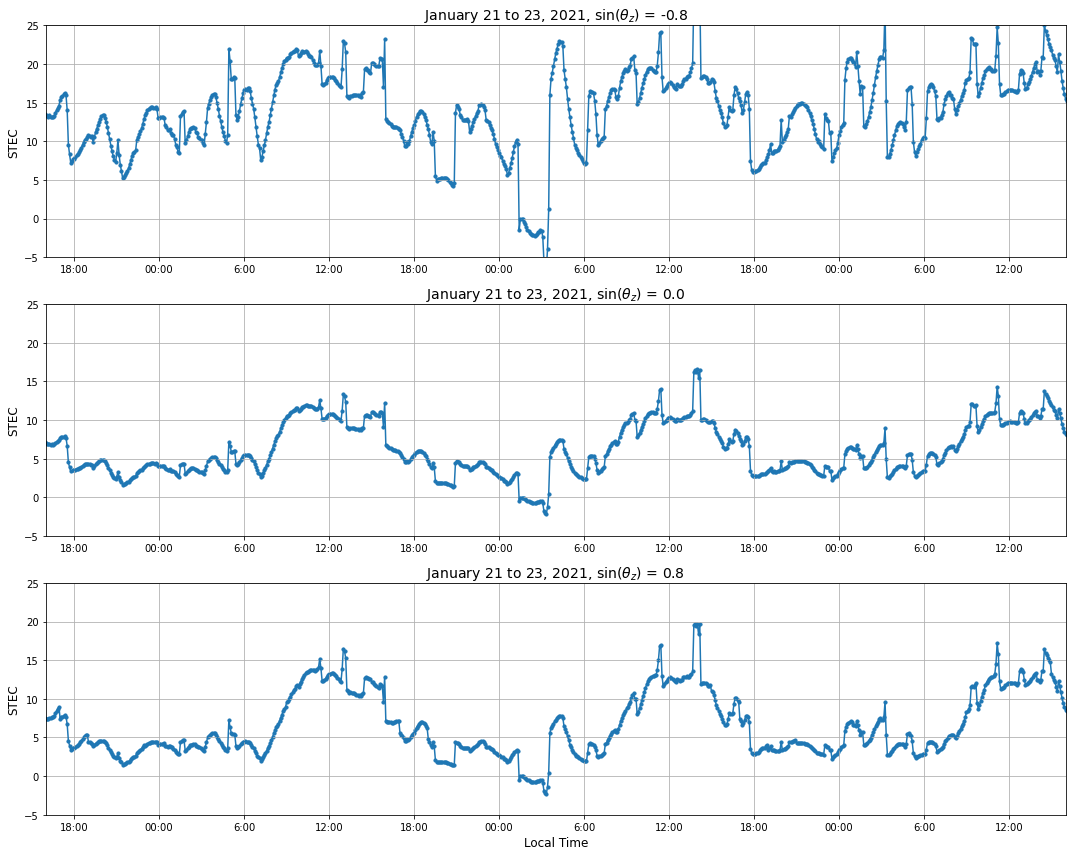

In [18]:
d_el = 2.5    # for now, elevation angles are incremented by 5 degrees
d_az = 179.95 # this is silly, but my hack for now to deal with weird azimuth values close to zenith

fs = 12
fig, axs = plt.subplots(len(el_pick), 1, figsize=(15,len(el_pick)*4))

for i in range(0,len(el_pick)):
    
    wD = np.where( (abs(abs(el_D)-el_pick[i])<d_el) & (abs(abs(az_D)-az_pick[i])<d_az) )
    #print(el_D[wD].shape)
    wA = np.where( (abs(abs(el_A)-el_pick[i])<d_el) & (abs(abs(az_A)-az_pick[i])<d_az) )
    #print(el_A[wA].shape)
    
    axs[i].scatter(t_hrs_D[wD],STEC_D[wD],s=10,color='C0',label=r'DRAO, sin($\theta_z$) = '+str(sin_za[i]))
    #axs[i].scatter(t_hrs_A[wA],STEC_A[wA],s=10,color='C1',label=r'Allenby, sin($\theta_z$) = '+str(sin_za[i]))

    axs[i].plot(t_hrs_D[wD],STEC_D[wD],color='C0')
    #axs[i].plot(t_hrs_A[wA],STEC_A[wA],color='C1')

    axs[i].set_xlim(-8,64)
    axs[i].set_ylim(-5,25)
    axs[i].grid()
    #axs[i].legend(fontsize=fs,loc=2)
    axs[i].set_ylabel('STEC',fontsize=fs)
    # Kinda brute force method for labeling the time axis. Should do something more robust:
    axs[i].set_xticks(ticks=[-6,0,6,12,18,24,30,36,42,48,54,60])
    axs[i].set_xticklabels(['18:00','00:00','6:00','12:00','18:00','00:00','6:00','12:00','18:00','00:00','6:00','12:00'])

    axs[i].set_title(r'January 21 to 23, 2021, sin($\theta_z$) = '+str(sin_za[i]),fontsize=fs+2)
    
#axs[0].set_title('January 21 to 23, 2021',fontsize=fs+4)
axs[len(el_pick)-1].set_xlabel('Local Time',fontsize=fs)

#plt.savefig('../PLOTS/DRAO_Allenby_STEC_Jan2021_350km.pdf')
plt.tight_layout()
plt.savefig('../PLOTS/DRAO_STEC_Jan2021_500km.pdf')

Try plotting with the giant error bars:

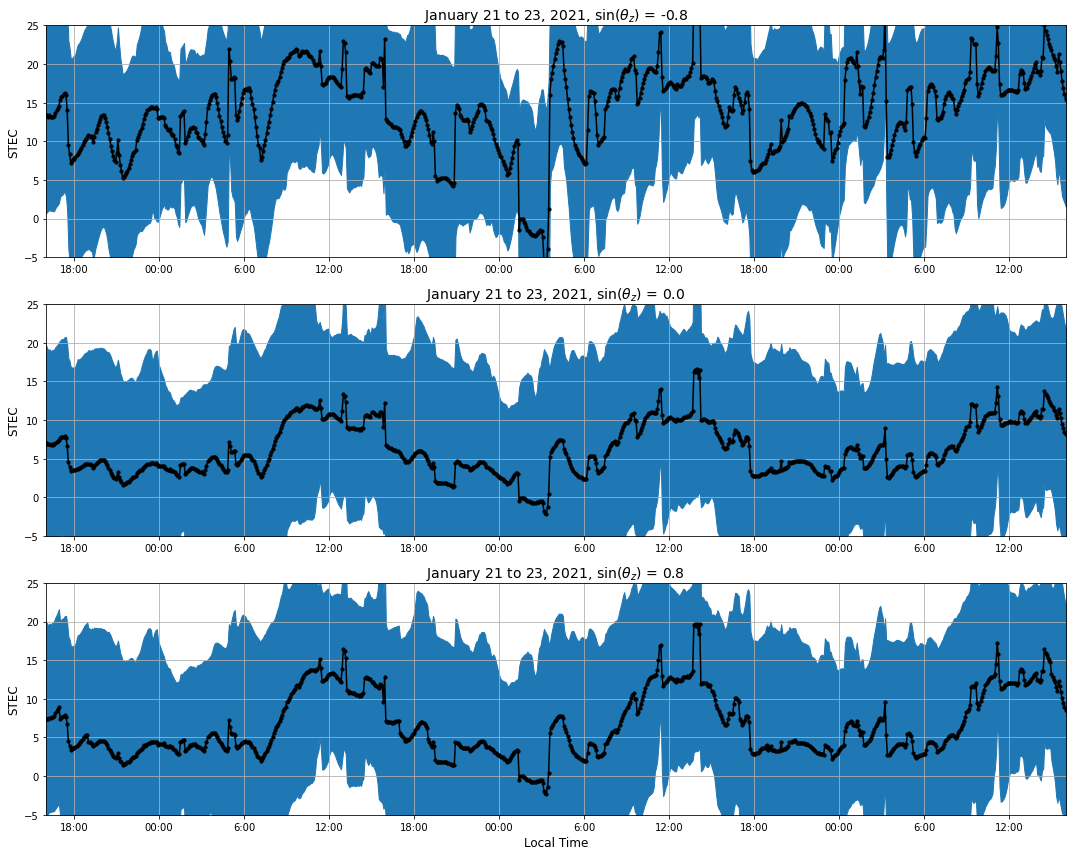

In [22]:
d_el = 2.5    # for now, elevation angles are incremented by 5 degrees
d_az = 179.95 # this is silly, but my hack for now to deal with weird azimuth values close to zenith

fs = 12
fig, axs = plt.subplots(len(el_pick), 1, figsize=(15,len(el_pick)*4))

for i in range(0,len(el_pick)):
    
    wD = np.where( (abs(abs(el_D)-el_pick[i])<d_el) & (abs(abs(az_D)-az_pick[i])<d_az) )
    #print(el_D[wD].shape)
    wA = np.where( (abs(abs(el_A)-el_pick[i])<d_el) & (abs(abs(az_A)-az_pick[i])<d_az) )
    #print(el_A[wA].shape)

    axs[i].scatter(t_hrs_D[wD],STEC_D[wD],s=10,color='black',label=r'DRAO, sin($\theta_z$) = '+str(sin_za[i]),zorder=200)
    #axs[i].scatter(t_hrs_A[wA],STEC_A[wA],s=10,color='C1',label=r'Allenby, sin($\theta_z$) = '+str(sin_za[i]))

    axs[i].plot(t_hrs_D[wD],STEC_D[wD],color='black',zorder=100)
    #axs[i].plot(t_hrs_A[wA],STEC_A[wA],color='C1')
    
    axs[i].fill_between(t_hrs_D[wD],STEC_D[wD]-dSTEC_D[wD],STEC_D[wD]+dSTEC_D[wD],color='C0',alpha=1,zorder=1)
    #axs[i].fill_between(t_hrs_A[wA],STEC_A[wA]-dSTEC_A[wA],STEC_A[wA]+dSTEC_A[wA],color='C1',alpha=0.5)

    axs[i].set_xlim(-8,64)
    axs[i].set_ylim(-5,25)
    axs[i].grid()
    #axs[i].legend(fontsize=fs,loc=2)
    axs[i].set_ylabel('STEC',fontsize=fs)
    # Kinda brute force method for labeling the time axis. Should do something more robust:
    axs[i].set_xticks(ticks=[-6,0,6,12,18,24,30,36,42,48,54,60])
    axs[i].set_xticklabels(['18:00','00:00','6:00','12:00','18:00','00:00','6:00','12:00','18:00','00:00','6:00','12:00'])

    axs[i].set_title(r'January 21 to 23, 2021, sin($\theta_z$) = '+str(sin_za[i]),fontsize=fs+2)
    
#axs[0].set_title('January 21 to 23, 2021',fontsize=fs+4)
axs[len(el_pick)-1].set_xlabel('Local Time',fontsize=fs)

plt.tight_layout()
plt.savefig('../PLOTS/DRAO_STEC_Jan2021_500km_errors.pdf')

Plot just the error bars:

Text(0.5, 0, 'Local Time')

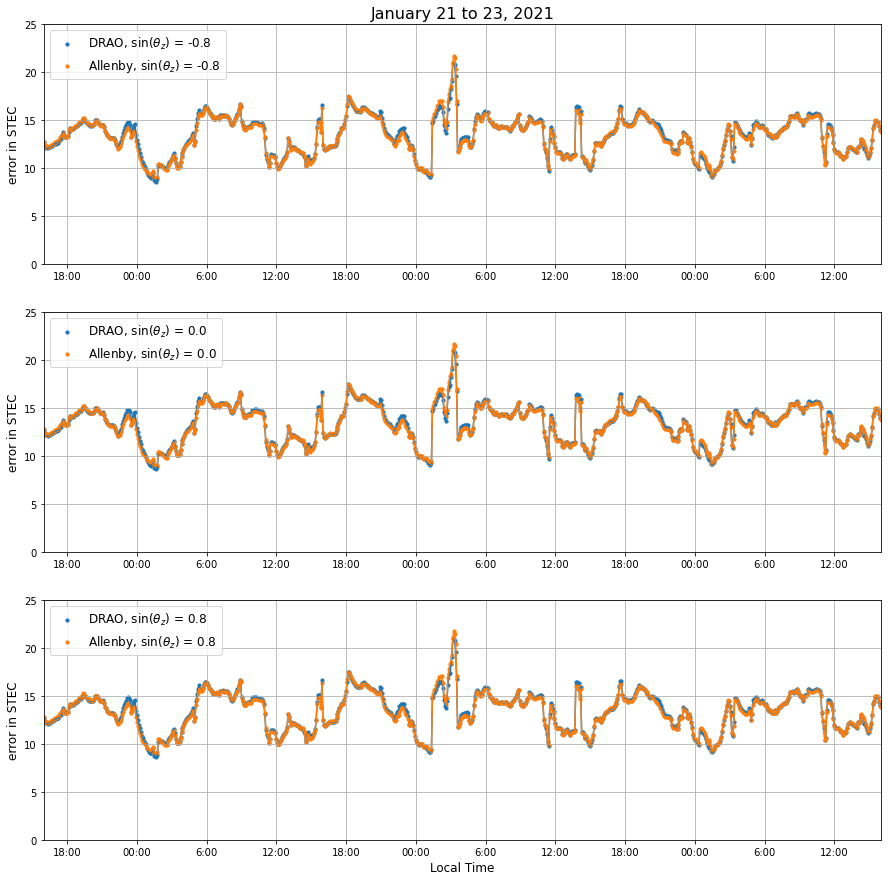

In [11]:
d_el = 2.5    # for now, elevation angles are incremented by 5 degrees
d_az = 179.95 # this is silly, but my hack for now to deal with weird azimuth values close to zenith

fs = 12
fig, axs = plt.subplots(len(el_pick), 1, figsize=(15,len(el_pick)*5))

for i in range(0,len(el_pick)):
    
    wD = np.where( (abs(abs(el_D)-el_pick[i])<d_el) & (abs(abs(az_D)-az_pick[i])<d_az) )
    #print(el_D[wD].shape)
    wA = np.where( (abs(abs(el_A)-el_pick[i])<d_el) & (abs(abs(az_A)-az_pick[i])<d_az) )
    #print(el_A[wA].shape)

    axs[i].scatter(t_hrs_D[wD],dSTEC_D[wD],s=10,color='C0',label=r'DRAO, sin($\theta_z$) = '+str(sin_za[i]))
    axs[i].scatter(t_hrs_A[wA],dSTEC_A[wA],s=10,color='C1',label=r'Allenby, sin($\theta_z$) = '+str(sin_za[i]))

    axs[i].plot(t_hrs_D[wD],dSTEC_D[wD],color='C0')
    axs[i].plot(t_hrs_A[wA],dSTEC_A[wA],color='C1')

    axs[i].set_xlim(-8,64)
    axs[i].set_ylim(0,25)
    axs[i].grid()
    axs[i].legend(fontsize=fs,loc=2)
    axs[i].set_ylabel('error in STEC',fontsize=fs)
    # Kinda brute force method for labeling the time axis. Should do something more robust:
    axs[i].set_xticks(ticks=[-6,0,6,12,18,24,30,36,42,48,54,60])
    axs[i].set_xticklabels(['18:00','00:00','6:00','12:00','18:00','00:00','6:00','12:00','18:00','00:00','6:00','12:00'])

axs[0].set_title('January 21 to 23, 2021',fontsize=fs+4)
axs[len(el_pick)-1].set_xlabel('Local Time',fontsize=fs)

Try comparing 5 minute increments to 20 minutes increments

In [12]:
DRAO_data_Jan2021_20m = '../DATA/albus_report_DRAO_CHIME_220121_3day_500km_20m'
Allenby_data_Jan2021_20m = '../DATA/albus_report_Allenby_CHIME_220121_3day_500km_20m'

In [13]:
#########################################################
UTCdiff = 8. # Note: set this to 8 for PST and 7 for PDT
#########################################################

imp.reload(subs)

# Note: 'D' stands for DRAO, 'A' for Allenby
TEC_D_20m, STEC_D_20m, dSTEC_D_20m, RM_D_20m, t_hrs_D_20m, el_D_20m, az_D_20m = subs.read_in_fitted_models_CHIME(DRAO_data_Jan2021_20m,UTCdiff)
TEC_A_20m, STEC_A_20m, dSTEC_A_20m, RM_A_20m, t_hrs_A_20m, el_A_20m, az_A_20m = subs.read_in_fitted_models_CHIME(Allenby_data_Jan2021_20m,UTCdiff)

Text(0.5, 0, 'Local Time')

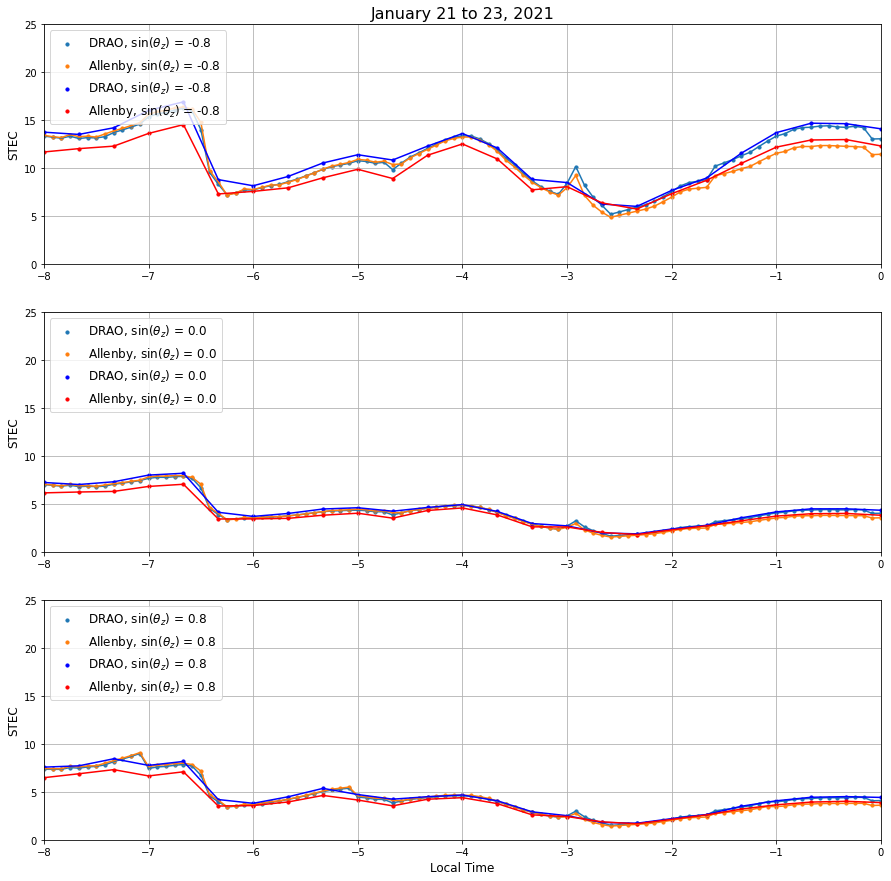

In [16]:
d_el = 2.5    # for now, elevation angles are incremented by 5 degrees
d_az = 179.95 # this is silly, but my hack for now to deal with weird azimuth values close to zenith

fs = 12
fig, axs = plt.subplots(len(el_pick), 1, figsize=(15,len(el_pick)*5))

for i in range(0,len(el_pick)):
    
    wD = np.where( (abs(abs(el_D)-el_pick[i])<d_el) & (abs(abs(az_D)-az_pick[i])<d_az) )
    wD_20m = np.where( (abs(abs(el_D_20m)-el_pick[i])<d_el) & (abs(abs(az_D_20m)-az_pick[i])<d_az) )
    #print(el_D[wD].shape)
    wA = np.where( (abs(abs(el_A)-el_pick[i])<d_el) & (abs(abs(az_A)-az_pick[i])<d_az) )
    wA_20m = np.where( (abs(abs(el_A_20m)-el_pick[i])<d_el) & (abs(abs(az_A_20m)-az_pick[i])<d_az) )
    #print(el_A[wA].shape)
    
    axs[i].scatter(t_hrs_D[wD],STEC_D[wD],s=10,color='C0',label=r'DRAO, sin($\theta_z$) = '+str(sin_za[i]))
    axs[i].scatter(t_hrs_A[wA],STEC_A[wA],s=10,color='C1',label=r'Allenby, sin($\theta_z$) = '+str(sin_za[i]))
    
    axs[i].scatter(t_hrs_D_20m[wD_20m],STEC_D_20m[wD_20m],s=10,color='blue',label=r'DRAO, sin($\theta_z$) = '+str(sin_za[i]))
    axs[i].scatter(t_hrs_A_20m[wA_20m],STEC_A_20m[wA_20m],s=10,color='red',label=r'Allenby, sin($\theta_z$) = '+str(sin_za[i]))

    axs[i].plot(t_hrs_D[wD],STEC_D[wD],color='C0')
    axs[i].plot(t_hrs_A[wA],STEC_A[wA],color='C1')
    
    axs[i].plot(t_hrs_D_20m[wD_20m],STEC_D_20m[wD_20m],color='blue')
    axs[i].plot(t_hrs_A_20m[wA_20m],STEC_A_20m[wA_20m],color='red')

    axs[i].set_xlim(-8,0)
    axs[i].set_ylim(0,25)
    axs[i].grid()
    axs[i].legend(fontsize=fs,loc=2)
    axs[i].set_ylabel('STEC',fontsize=fs)
    ## Kinda brute force method for labeling the time axis. Should do something more robust:
    #axs[i].set_xticks(ticks=[-6,0,6,12,18,24,30,36,42,48,54,60])
    #axs[i].set_xticklabels(['18:00','00:00','6:00','12:00','18:00','00:00','6:00','12:00','18:00','00:00','6:00','12:00'])

axs[0].set_title('January 21 to 23, 2021',fontsize=fs+4)
axs[len(el_pick)-1].set_xlabel('Local Time',fontsize=fs)

#plt.savefig('../PLOTS/DRAO_Allenby_STEC_Jan2021_350km.pdf')